To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

**Read our [blog post](https://unsloth.ai/blog/r1-reasoning) for guidance to train reasoning model.** GRPO notebook is inspired by [@shxf0072](https://x.com/shxf0072/status/1886085377146180091), [@Teknium1](https://x.com/Teknium1/status/1885077369142337550), [@willccbb](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb)

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
    !pip install --no-deps cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.9: Fast Qwen2_Vl patching. Transformers: 4.49.0.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model` require gradients


In [4]:
from datasets import load_dataset
dataset = load_dataset("Chakita/SMILE","single_folder",split="train")

In [5]:
dataset

Dataset({
    features: ['images', 'conversation', 'image_tag_mapping', 'conversation_id'],
    num_rows: 3000
})

In [6]:
import re
import base64
from PIL import Image
from io import BytesIO


def convert_format(data):
    converted_data = []

    # Extract conversation parts
    conversation_text = data["conversation"]

    if len(data["images"])>2:
        return None

    # Collect all images from the image_tag_mapping
    all_images = []
    referenced_images = set()
    image_tag_pattern = r'<([^>]+)>'

    # First check if there are any image tags in the conversation
    for j,match in enumerate(re.finditer(image_tag_pattern, conversation_text)):
        full_tag = match.group(0)  # The entire tag with brackets
        img_tag = f"<img_{j+1}>"
        img_filename = data["image_tag_mapping"].get(img_tag)

        if img_filename:
            referenced_images.add(img_filename)
            for img in data["images"]:
                if img["name"] == img_filename:
                    # Decode base64 to PIL Image
                    base64_data = img["base64"]
                    image_bytes = base64.b64decode(base64_data)
                    pil_image = Image.open(BytesIO(image_bytes))

                    all_images.append({"type": "image", "image": pil_image})
                    break

    # Now check for any images in the data that weren't referenced
    for img_tag, img_filename in data["image_tag_mapping"].items():
        if img_filename not in referenced_images:
            for img in data["images"]:
                if img["name"] == img_filename:
                    # Decode base64 to PIL Image
                    base64_data = img["base64"]
                    image_bytes = base64.b64decode(base64_data)
                    pil_image = Image.open(BytesIO(image_bytes))

                    all_images.append({"type": "image", "image": pil_image})
                    break

    # Now process the conversation normally
    parts = re.split(r'(HUMAN:|BOT:|\[HUMAN\]|\[BOT\])', conversation_text)
    parts = [p for p in parts if p.strip()]  # Remove empty parts

    # Group the parts into human and bot messages
    i = 0
    while i < len(parts):
        # Check if this part is a human marker
        if parts[i] in ["HUMAN:", "[HUMAN]"] and i + 1 < len(parts):
            human_text = parts[i+1].strip()

            # For the first human message, add all images
            if len(converted_data) == 0:
                content = all_images.copy()  # Add all images to first user message

                # Remove image tags from text
                clean_text = re.sub(image_tag_pattern, '', human_text).strip()

                if clean_text:
                    content.append({"type": "text", "text": clean_text})

                converted_data.append({"role": "user", "content": content})
            else:
                # For subsequent human messages, just add the text
                clean_text = re.sub(image_tag_pattern, '', human_text).strip()

                if clean_text:
                    converted_data.append({
                        "role": "user",
                        "content": [{"type": "text", "text": clean_text}]
                    })

            i += 2

        # Check if this part is a bot marker
        elif parts[i] in ["BOT:", "[BOT]"] and i + 1 < len(parts):
            # Process bot message
            bot_text = parts[i+1].strip()

            # Remove image tags from text
            clean_text = re.sub(image_tag_pattern, '', bot_text).strip()

            converted_data.append({
                "role": "assistant",
                "content": [{"type": "text", "text": clean_text}]
            })

            i += 2

        else:
            # Handle unexpected pattern
            i += 1

    return {"messages": converted_data}

In [7]:
convert_format(dataset[1])

{'messages': [{'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=101x101>},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=68x68>},
    {'type': 'text', 'text': 'Who are these anime girls?'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'These appear to be illustrations of anime-style female characters.  The first image, , shows a character with long blonde hair, while the second, , depicts a character with brown hair and larger eyes.  I cannot identify specific characters.  Are you interested in learning more about the art style or the creation of anime characters?'}]}]}

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

Let's convert the dataset into the "correct" format for finetuning:

In [8]:
converted_dataset = [convert_format(sample) for sample in dataset if convert_format(sample) is not None]

We look at how the conversations are structured for the first example:

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>


Let's first see before we do any finetuning what the model outputs for the first example!

In [9]:
converted_dataset[1]

{'messages': [{'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=101x101>},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=68x68>},
    {'type': 'text', 'text': 'Who are these anime girls?'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'These appear to be illustrations of anime-style female characters.  The first image, , shows a character with long blonde hair, while the second, , depicts a character with brown hair and larger eyes.  I cannot identify specific characters.  Are you interested in learning more about the art style or the creation of anime characters?'}]}]}

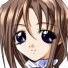

In [10]:
converted_dataset[1]["messages"][0]["content"][1]["image"]

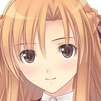

In [11]:
converted_dataset[1]["messages"][0]["content"][0]["image"]

In [12]:
FastVisionModel.for_inference(model) # Enable for inference!

image_1 = converted_dataset[1]["messages"][0]["content"][0]["image"]
image_2 = converted_dataset[1]["messages"][0]["content"][1]["image"]
instruction = "Can you tell me who these anime characters are?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type":"image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    [image_1,
    image_2],
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The characters in the images are from the anime series "Sword Art Online." The character in the first image is Asuna, and the character in the second image is Yui.<|im_end|>


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [16]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 54,
        #num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [17]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.168 GB.
17.387 GB of memory reserved.


In [18]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,182 | Num Epochs = 1 | Total steps = 54
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 40,370,176/5,052,717,568 (0.80% trained)


Step,Training Loss
1,0.935200
2,1.084900
3,0.870500
4,1.146500
5,0.878500
6,1.046200
7,0.919700
8,1.021700
9,0.820500
10,0.740500


In [19]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

305.7671 seconds used for training.
5.1 minutes used for training.
Peak reserved memory = 17.875 GB.
Peak reserved memory for training = 0.488 GB.
Peak reserved memory % of max memory = 80.634 %.
Peak reserved memory for training % of max memory = 2.201 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [20]:
FastVisionModel.for_inference(model) # Enable for inference!

image = converted_dataset[1]["messages"][0]["content"][0]["image"]
instruction = "Who is this?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

That's a drawing of a young woman with long blonde hair and brown eyes.  The style is reminiscent of anime or manga.  Is there anything else I can help you with regarding this image?<|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
# model.save_pretrained("lora_model")  # Local saving
# tokenizer.save_pretrained("lora_model")
model.push_to_hub("Chakita/Qwen_SMILE_finetuned_single_folder", token = "") # Online saving
tokenizer.push_to_hub("Chakita/Qwen_SMILE_finetuned_single_folder", token = "") # Online saving

README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/162M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Chakita/Qwen_SMILE_finetuned_single_folder


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [22]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = converted_dataset[1]["messages"][0]["content"][0]["image"]
instruction = "Can you identify this person?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

I cannot identify specific people in the image.  The image shows a young woman with long blonde hair and brown eyes. She appears to be wearing a light-colored top.  The style suggests it might be an anime character.  Is there anything else I can help you with regarding this image?<|im_end|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("Chakita/unsloth_finetune", tokenizer, token = "")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

If you want to finetune Llama-3 2x faster and use 70% less VRAM, go to our [finetuning notebook](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing)!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. Gemma 6 trillion tokens is 2.5x faster! [free Colab](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

 Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>


In [ ]:
! zip -r  /content/finetuned.zip /content/outputs